In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt

In [4]:
from data_generators import inf_train_gen

In [5]:
num_target = 5000
target_samples = 20 * inf_train_gen('2spirals',rng = 50,batch_size = num_target)
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(5000,2))

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-05-13 17:24:19.522764: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 512, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(0.5*jnp.pi*t)*x + jnp.sin(0.5*jnp.pi*t)*y

def It(t,x,y):
    return -0.5*jnp.pi*jnp.sin(0.5*jnp.pi*t)*x + 0.5*jnp.pi*jnp.cos(0.5*jnp.pi*t)*y
# def I(t,x,y):
#     return (1-t)*x + t*y

# def It(t,x,y):
#     return y-x



def gamma(t):
    return jnp.sqrt(2*t*(1-t))
gammadot = vmap(vmap(grad(gamma)))
gamma_coef = 0


@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)])
    bhat = jax.vmap(model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gamma_coef * gammadot(t)*z)*bhat,axis=1))
    dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

In [97]:
t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)

Array(-8.955532, dtype=float32)

In [98]:
def get_trainloader(batch_size = 128):
    for i in range(10**6):
        trainloader_key = jax.random.PRNGKey(i)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))#jax.random.permutation(shuffle_ref_key,reference_samples)
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))
        #target_batch = jax.random.permutation(shuffle_target_key,target_samples)

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader(batch_size = 1000):
    num_batches = 400
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

def evaluate(model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(model,t,x,y,z)
    return avg_loss / 400


In [99]:
def train(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    test_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), trainloader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate(model, testloader)
            test_losses.append(test_losses)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses,test_losses

In [129]:
learning_rate = 1e-3

optim = optax.chain(
   optax.adam(learning_rate),
)
model = NeuralNetwork(jax.random.PRNGKey(420))
trainloader = get_trainloader(batch_size = 1024)

model,losses,test_losses = train(model,optim,steps=100001,train_loader=trainloader,print_every=10000)

step=0 | train_loss=184.9531 | test_loss= -4.0147038
step=10000 | train_loss=-2071.1655 | test_loss= -1971.7603
step=20000 | train_loss=-1925.882 | test_loss= -1981.1962
step=30000 | train_loss=-1939.5598 | test_loss= -1981.9615
step=40000 | train_loss=-1989.8047 | test_loss= -1982.2439
step=50000 | train_loss=-1930.6443 | test_loss= -1982.6694
step=60000 | train_loss=-1973.6434 | test_loss= -1983.3069
step=70000 | train_loss=-1980.3118 | test_loss= -1983.9847
step=80000 | train_loss=-2007.9656 | test_loss= -1984.6973
step=90000 | train_loss=-1970.8223 | test_loss= -1985.0308
step=100000 | train_loss=-2018.2808 | test_loss= -1985.5989


ValueError: not enough values to unpack (expected 3, got 2)

In [118]:
train_loss = jnp.array(losses)

In [124]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


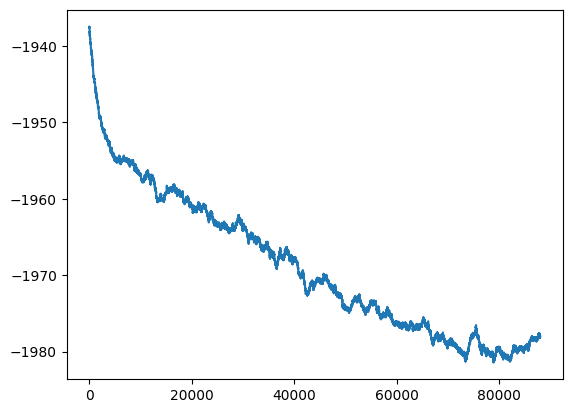

In [128]:
plt.plot(moving_average(np.array(train_loss),2000)[10000:])

In [111]:
vmapped_model = vmap(model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_model(jnp.hstack([t_vec,x]))

In [112]:
term = ODETerm(dX_t)
solver = Dopri5()
t0 = 0
t1 = 1
dt0 = 0.1
X0 = jax.random.normal(jax.random.PRNGKey(132),(20000,2))
saveat = SaveAt(ts=jnp.linspace(t0, t1, 10))
sol = diffeqsolve(term, solver, t0, t1, dt0, X0, saveat=saveat)


In [113]:
final = sol.ys[-1]
initial = X0

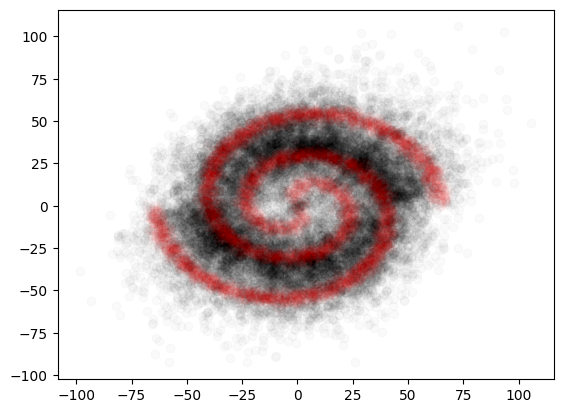

In [114]:
#plt.scatter(initial[:,0],initial[:,1],c='red',alpha = 0.02)
plt.scatter(final[:,0],final[:,1],c='black',alpha = 0.02)


plt.scatter(target_samples[:,0],target_samples[:,1],c='red',alpha = 0.02)

# for i in range(0,len(sol.ys[0]),200):
#     plt.plot(sol.ys[:,i,0],sol.ys[:,i,1],c='blue',alpha = 1,lw = 1)

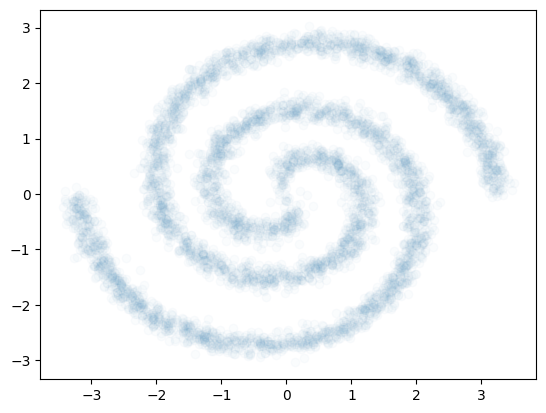

In [65]:
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.02)